<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/Copy_of_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
# <div align="center"><font>  </font></div>
# <div align="center"><font> COSC 2793 Computational Machine Learning </font></div>
## <div align="center"> <font> Assignment 2: Machine Learning Project </font></div>
## <div align="center"> <font> S3930776 Afrah Hassan A Alshaikh Ali & S3569266 Chang Su </font></div>
---

In [10]:
import os
import csv
import zipfile
import pandas as pd
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from PIL import Image

Workflow
We need to follow the below 4 steps to build our traffic sign classification model:

Dataset exploration
CNN model building
Model training and validation
Model testing
https://www.analyticsvidhya.com/blog/2021/12/traffic-signs-recognition-using-cnn-and-keras-in-python/


# **1. Load and Preprocess the Data**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
os.listdir('/content/drive/MyDrive/Assignment2')

['assignment2_PG.pdf',
 'COSC2673_2793_A2_EOI_.docx',
 'assignment2.ipynb',
 'trafficsigns_dataset.zip',
 'trafficsigns_dataset',
 'shape.csv',
 'type.csv',
 'combined_data.csv']

In [10]:
!cp -r "/content/drive/MyDrive/Assignment2" .

# **Reading Data and preprocessing**

In [7]:


extract_to_path = '/content/drive/MyDrive/Assignment2'
output_csv = '/content/drive/My Drive/Assignment2/combined_data.csv'
data_list = []

for root, dirs, files in os.walk(extract_to_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            full_path = os.path.join(root, file)
            class_name = os.path.basename(os.path.dirname(root))
            img = Image.open(full_path).convert('L')
            img = img.resize((28, 28))
            img_array = np.array(img, dtype=np.float32)
            img_array = img_array.reshape(28, 28, 1)
            data_list.append({'image_path': full_path, 'class': class_name, 'image_array': img_array.tolist()})

data = pd.DataFrame(data_list)
encoder = LabelEncoder()
data['encoded_class'] = encoder.fit_transform(data['class'])
class_labels_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Mapping of classes to encoded labels:", class_labels_mapping)
data.to_csv(output_csv, index=False)
print(f"CSV file has been created successfully with {len(data)} entries at {output_csv}")

Mapping of classes to encoded labels: {'diamond': 0, 'hex': 1, 'round': 2, 'square': 3, 'triangle': 4}
CSV file has been created successfully with 3699 entries at /content/drive/My Drive/Assignment2/combined_data.csv


# **Data Exploration**

In [8]:
data['exists'] = data['image_path'].apply(os.path.exists)

num_files_exist = data['exists'].sum()

num_files_missing = len(data) - num_files_exist

print(f"Number of existing files: {num_files_exist}")
print(f"Number of missing files: {num_files_missing}")


Number of existing files: 3699
Number of missing files: 0


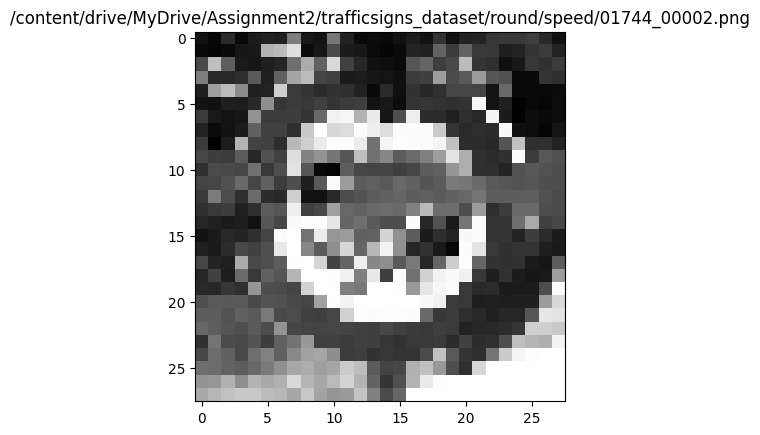

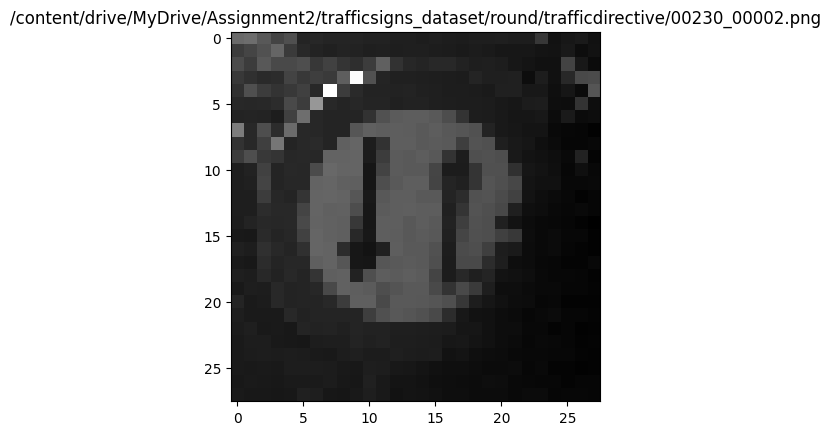

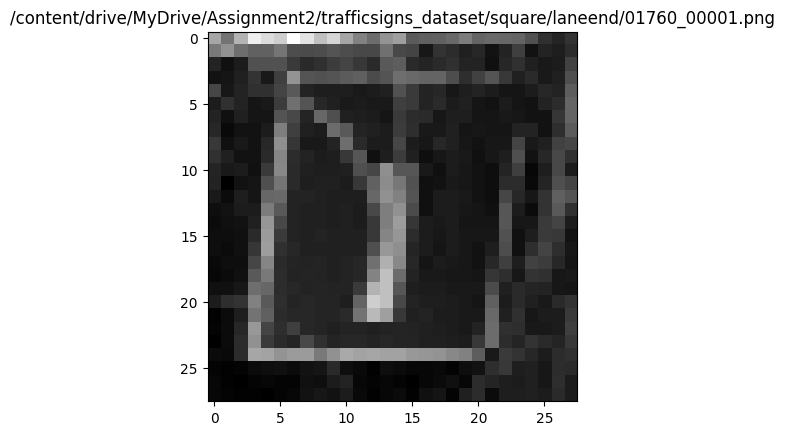

In [11]:
sample_images = data['image_path'].sample(3).tolist()
for img_path in sample_images:
    img = Image.open(img_path)
    img_array = np.array(img)
    plt.imshow(img_array, cmap='gray')
    plt.title(img_path)
    plt.show()

In [12]:
print(data.isnull().sum())
print(data['class'].unique())

image_path       0
class            0
image_array      0
encoded_class    0
exists           0
dtype: int64
['square' 'triangle' 'hex' 'round' 'diamond']


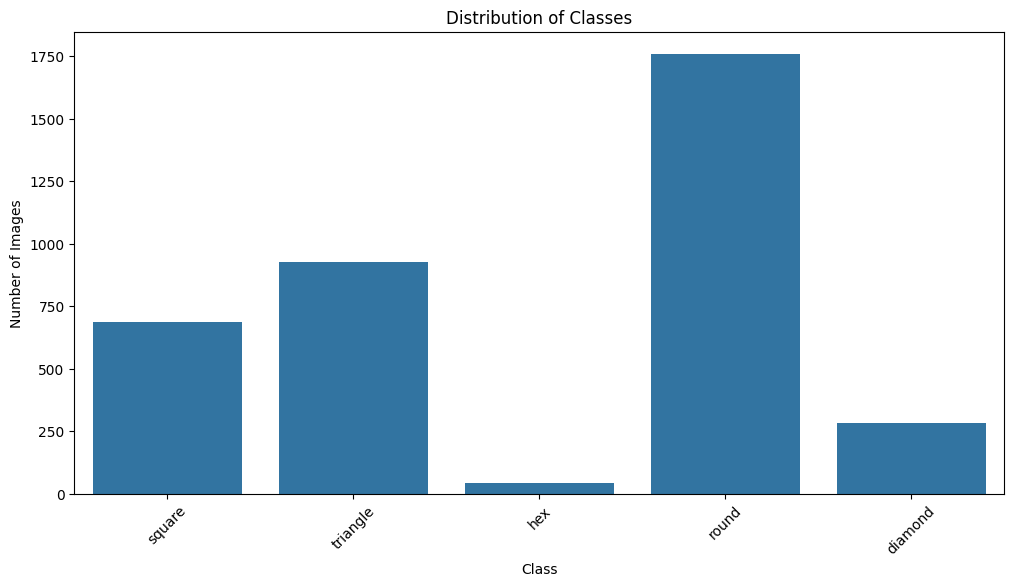

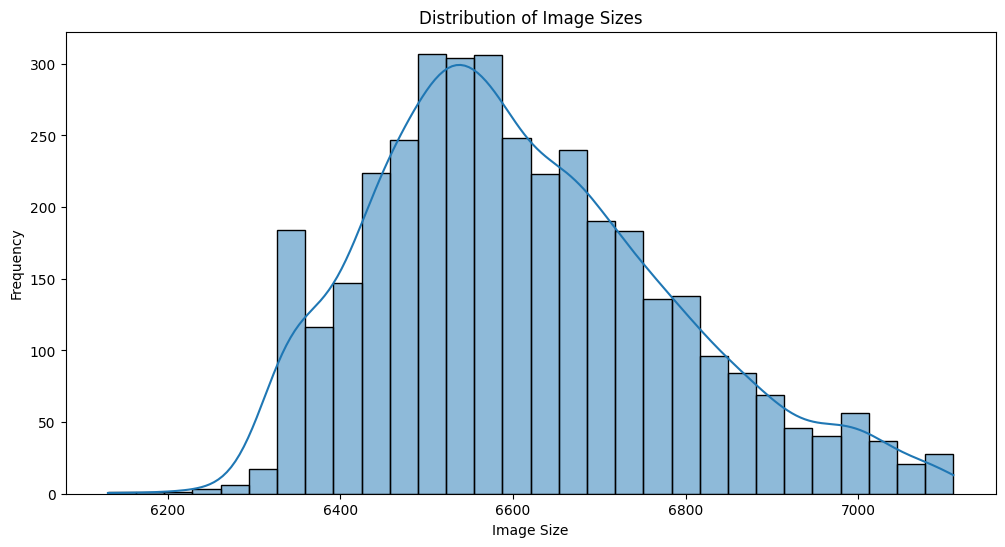

In [13]:
import seaborn as sns

data = pd.read_csv('/content/drive/My Drive/Assignment2/combined_data.csv')

# Convert the flat list of image arrays into a numpy array to calculate their sizes
data['image_size'] = data['image_array'].apply(lambda x: len(x))

# Plot the distribution of classes
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='class')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of image sizes
plt.figure(figsize=(12, 6))
sns.histplot(data['image_size'], bins=30, kde=True)
plt.title('Distribution of Image Sizes')
plt.xlabel('Image Size')
plt.ylabel('Frequency')
plt.show()


# **Data Splitting**

In [14]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/drive/My Drive/Assignment2/combined_data.csv')

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


# **Base model**

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


In [16]:
# Assuming each row in your CSV file has image data in a column named 'image_array' as flattened arrays
# And 'encoded_class' is the column with label data

# Convert stringified arrays back into actual numpy arrays and normalize pixel values
data['image_array'] = data['image_array'].apply(lambda x: np.array(eval(x)).reshape(28, 28, 1) / 255.0)

# Preparing the labels
label_encoder = LabelEncoder()
data['encoded_class'] = label_encoder.fit_transform(data['class'])

# Splitting the dataset again with the preprocessed data
x = np.stack(data['image_array'])  # This creates a proper numpy array from the series of arrays
y = to_categorical(data['encoded_class'])  # Convert labels to one-hot encoding

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)


In [17]:
def create_base_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create model
num_classes = y_train.shape[1]
model = create_base_model((28, 28, 1), num_classes)

# Display the model architecture
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,389 (876.52 KB)

 Trainable params: 224,389 (876.52 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5460 - loss: 1.2140 - val_accuracy: 0.8730 - val_loss: 0.4645
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8805 - loss: 0.4406 - val_accuracy: 0.9568 - val_loss: 0.1853
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9313 - loss: 0.2267 - val_accuracy: 0.9743 - val_loss: 0.0995
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9571 - loss: 0.1278 - val_accuracy: 0.9851 - val_loss: 0.0715
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9754 - loss: 0.0872 - val_accuracy: 0.9878 - val_loss: 0.0568
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9872 - loss: 0.0592 - val_accuracy: 0.9865 - val_loss: 0.0500
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9894 - loss: 0.0459 - val_accuracy: 0.9878 - val_loss: 0.0524
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9902 - loss: 0.0367 - val_accuracy: 0.9905 - v

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9870 - loss: 0.0430
Test accuracy: 0.9837837815284729


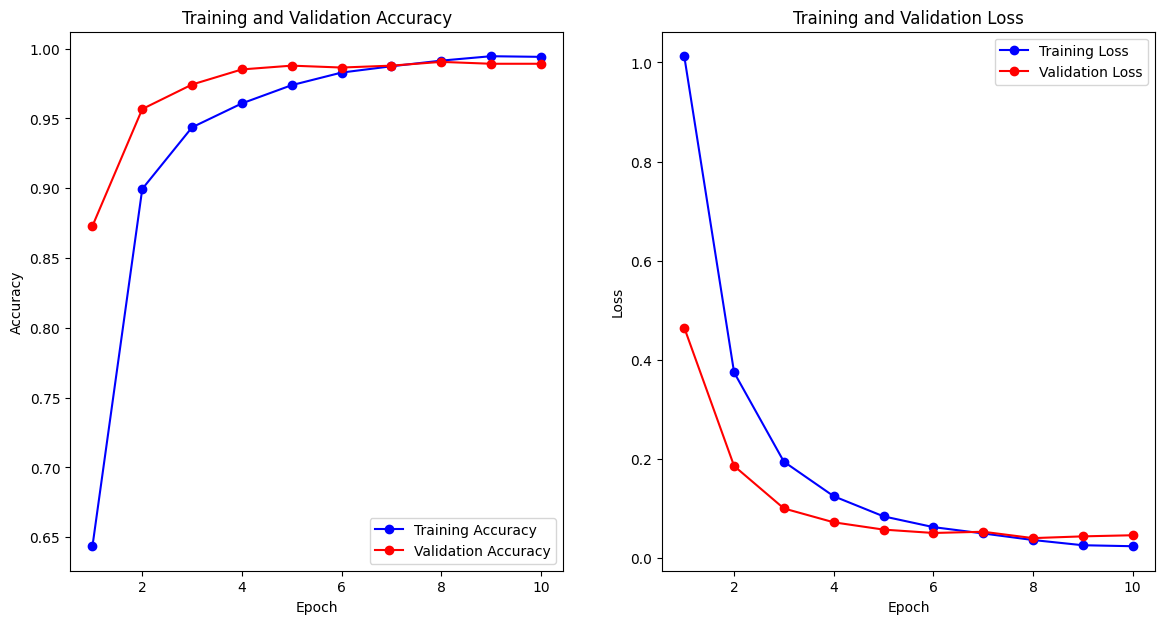

In [20]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)  # دقة
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # lose
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

cr = classification_report(true_classes, predicted_classes)
print(cr)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
[[ 55   0   1   0   0]
 [  0   7   1   0   0]
 [  0   0 330   0   1]
 [  0   0   1 152   5]
 [  0   0   3   0 184]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       1.00      0.88      0.93         8
           2       0.98      1.00      0.99       331
           3       1.00      0.96      0.98       158
           4       0.97      0.98      0.98       187

    accuracy                           0.98       740
   macro avg       0.99      0.96      0.97       740
weighted avg       0.98      0.98      0.98       740



# **Improvement the model **

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,       # Reduce learning rate by a factor of 0.2
    patience=5,       # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.001      # Lower bound on the learning rate
)
# Assuming you have already defined your model and have prepared your training and validation data
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9967 - loss: 0.0195 - val_accuracy: 0.9919 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9949 - loss: 0.0182 - val_accuracy: 0.9919 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9961 - loss: 0.0231 - val_accuracy: 0.9878 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9949 - loss: 0.0186 - val_accuracy: 0.9892 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9977 - loss: 0.0099 - val_accuracy: 0.9851 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9943 - loss: 0.0235 - val_accuracy: 0.9932 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9940 - loss: 0.0229 - val_acc

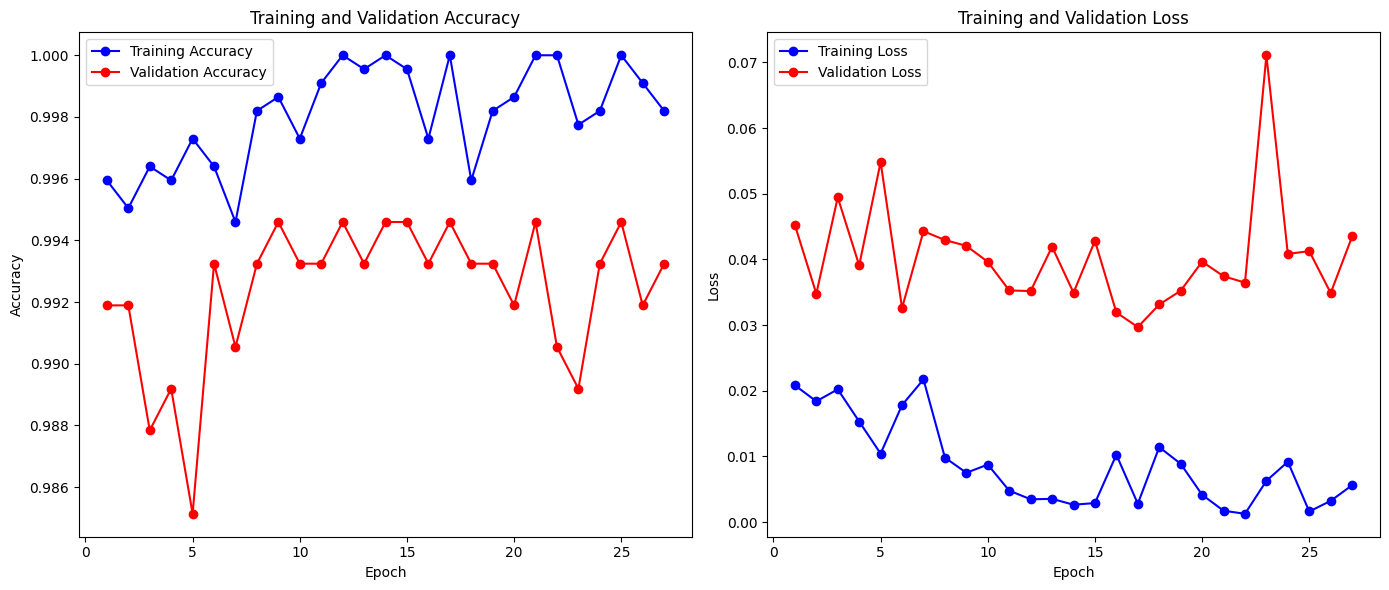

In [25]:
def plot_training_history(history):
    # Extracting the accuracy and loss from the training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the graphs using the history object returned from model.fit()
plot_training_history(history)


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [41]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# Checkpoint to save the best model version based on validation loss
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Data augmentation for robustness
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,       # Reduce learning rate by a factor of 0.2
    patience=5,       # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.001      # Lower bound on the learning rate
)
# Assuming you have already defined your model and have prepared your training and validation data
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9905 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9946 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9983 - loss: 0.0068 - val_accuracy: 0.9959 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9950 - loss: 0.0133 - val_accuracy: 0.9919 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 0.9946 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.9892 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9974 - loss: 0.0060 - val_acc

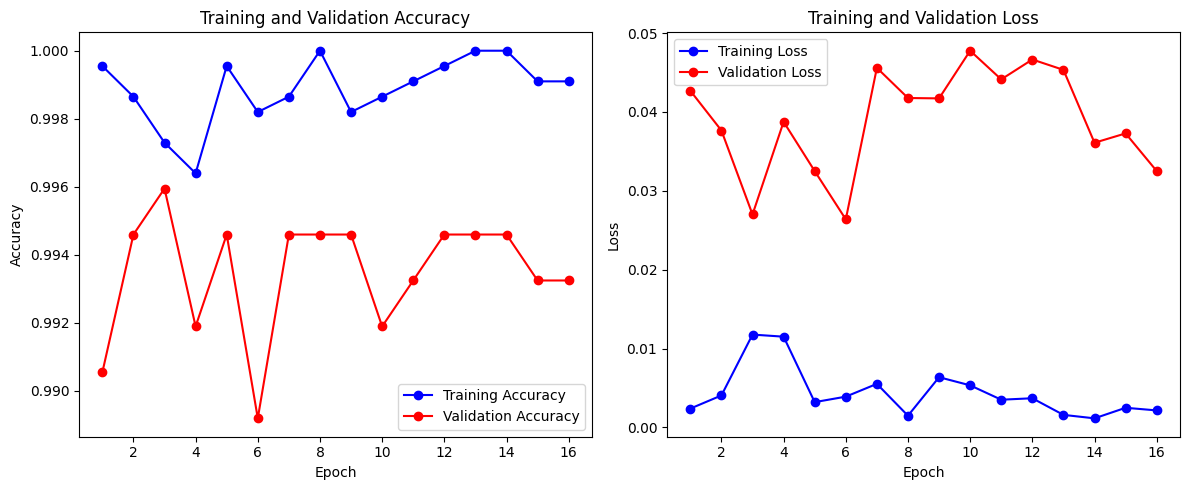

In [44]:
def plot_training_history(history):
    # Extract accuracy and loss for training and validation sets
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Assuming 'history' is the variable containing the history object from your model training
plot_training_history(history)


# **EDA**
Model development

3. Choose a Model

4. Train the Model

5. Evaluate the Model

In [80]:
print(x_train.shape, y_train.shape)  # تحقق من أبعاد البيانات
print(x_train.min(), x_train.max())  # يجب أن تكون القيم بين 0 و 1


(2219, 28, 28, 1) (2219, 5)
0.0 0.00392156862745098


In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# تحميل البيانات
data = pd.read_csv('/content/drive/My Drive/Assignment2/combined_data.csv')

# تحويل القائمة المسطحة للصور إلى مصفوفات numpy
data['image_array'] = data['image_array'].apply(lambda x: np.array(eval(x)).reshape(28, 28, 1))

# تقسيم البيانات إلى مجموعات التدريب والتحقق والاختبار
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# تحويل الصور إلى النطاق [0, 1]
x_train = np.array(train_data['image_array'].tolist()) / 255.0
x_val = np.array(val_data['image_array'].tolist()) / 255.0
x_test = np.array(test_data['image_array'].tolist()) / 255.0

# تحويل الفئات إلى تنسيق one-hot encoding
y_train = to_categorical(train_data['encoded_class'])
y_val = to_categorical(val_data['encoded_class'])
y_test = to_categorical(test_data['encoded_class'])

# الآن يمكنك تدريب النموذج
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))١٣import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [69]:
def create_model():
    model = Sequential([
        # الطبقة الأولى: طبقة التلافظ
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(2, 2),

        # الطبقة الثانية: طبقة التلافظ
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # تسطيح البيانات لإدخالها في الطبقات الكثيفة
        Flatten(),

        # طبقة كثيفة مع 128 عقدة
        Dense(128, activation='relu'),

        # تقليل الإفراط في التكيف باستخدام Dropout
        Dropout(0.5),

        # الطبقة الخروجية مع عدد الفئات، فلنقل لدينا 10 فئات
        Dense(10, activation='softmax')
    ])

    # تجهيز النموذج
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [70]:
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [73]:
# فرض أن x_train وy_train هي بيانات التدريب، وx_val وy_val هي بيانات التحقق
# تأكد من أن البيانات معدلة بشكل صحيح، بما في ذلك تحويل الصور إلى النطاق [0, 1]

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


NameError: name 'x_train' is not defined